In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import scipy.io as io
import pandas as pd
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy import interpolate
import torch

Text(0.5, 0, 'wavelength [nm]')

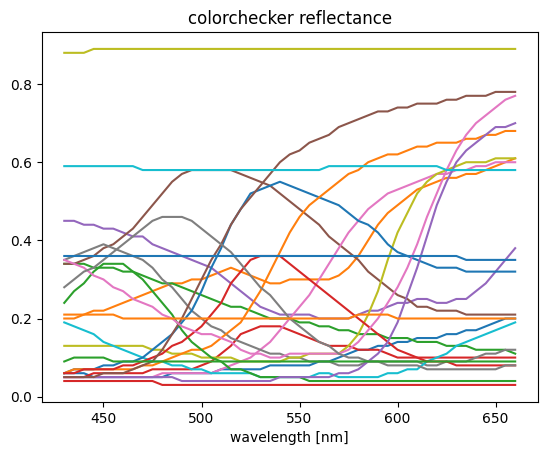

In [2]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [45]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

depth_start = 600
depth_end = 900     
depth_arange = np.arange(depth_start, depth_end + 1, 1)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

# date of datas
date = "1003"

real_data_dir = "./dataset/data/2023%s_real_data/"%date
# opt_param_dir = "./calibration/radiometric_cal/opt_params/opt_param_0915_detach_09500.npy"
opt_param_dir = "./calibration/radiometric_cal/opt_params/opt_param_1021_detach_09500.npy"

# center points for all patches 20231003
all_patches_center_pts = np.array([[200,160], [300,150], [418,142], [533,133],[651, 129], [770,100],
                                    [200,276], [308,267], [420,260], [537,251], [655,245], [780,237],
                                    [202,386], [310,382], [420,375], [540,375], [660,368], [780,360],
                                    [200,500], [300,490], [420,500], [540,500], [660,490], [790,480]])

# # center points for all patches 20231022(2)
# all_patches_center_pts = np.array([[268,71], [368,94], [464,114], [560,130],[648,146], [730,163],
#                                     [260,190], [365,200], [460,220], [555,235], [644,252], [727,262],
#                                     [255,300], [360,324], [463,329], [555,343], [641,354], [723,361],
#                                     [251,432], [357,437], [458,443], [550,450], [641,457], [721,465]])

# # center points for all patches 20231022
# all_patches_center_pts = np.array([[293,120], [400,120], [500,120], [608,115],[717,116], [822,115],
#                                     [293,227], [395,218], [507,220], [613,220], [720,220], [830,220],
#                                     [290,320], [400,324], [500,327], [610,328], [720,324], [830,324],
#                                     [288,432], [400,433], [500,436], [615,434], [722,435], [832,428]])

# # center points for all patches 20231016
# all_patches_center_pts = np.array([[187,206], [186,247], [187,286], [187,323],[187, 366], [187,405],
#                                     [150,207], [150,246], [145,284], [145,322], [145,365], [145,406],
#                                     [108,205], [108,243], [105,284], [104,326], [105,363], [104,402],
#                                     [68,203], [68,242], [68,283], [64,320], [63,362], [62,404]])


# # center points for all patches 20231002
# all_patches_center_pts = np.array([[120,80], [260,90], [390,90], [510,100], [640,100], [770,100],
#                                     [118,200], [250,200], [386,220], [510,220], [650,220], [770,220],
#                                     [115,339], [246,340], [380,340], [520,350], [640,350], [770,350],
#                                     [100,470], [240,480], [380,480], [510,480], [650,480], [770,480]])

# # # center points for all patches 20230926
# all_patches_center_pts = np.array([[144, 170], [255,180], [360,189], [467, 190], [575,200], [675,200],
# [140,280], [250,290], [360,290], [460,300], [570,300], [670,300],
# [140,390], [250,400], [360,400], [460,400], [570,410], [675,407],
# [133,500], [240,506], [350,500], [460,500], [570,500], [676,510]])

# ## center patches
# all_patches_center_pts = np.array([[120,80], [260,90], [390,90], [510,100], [640,100], [770,100],
#                                     [118,200], [250,200], [386,220], [510,220], [650,220], [770,220],
#                                     [115,339], [246,340], [380,340], [520,350], [640,350], [770,350],
#                                     [100,470], [240,480], [380,480], [510,480], [650,480], [770,480]])

### PEF, CRF, DG Efficiency

In [4]:
# bring initial value of PEF and CRF
PEF = np.load('./dataset/image_formation/PEF.npy')
CRF = np.load('./dataset/image_formation/CRF.npy') # from 430nm
DG_efficiency = np.load('./dataset/image_formation/DG.npy') # from 430nm

new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

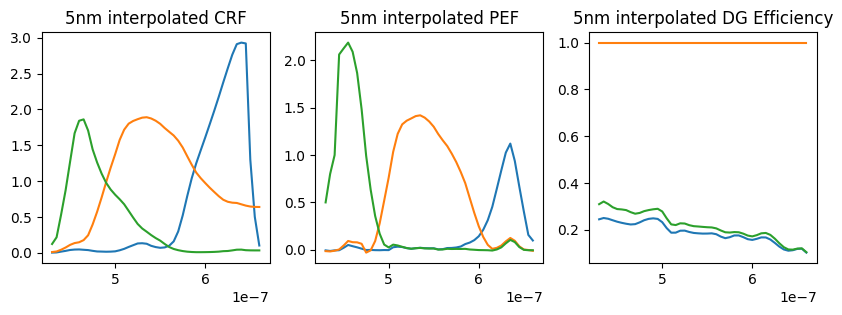

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

In [6]:
# plt.plot(new_wvls, DG_efficiency[0]), plt.title('5nm interpolated DG Efficiency')
# plt.plot(new_wvls, DG_efficiency[2]), plt.title('5nm interpolated DG Efficiency')

In [7]:
# DG_efficiency[2, :7] = DG_efficiency[2, :7] + 0.115
# DG_efficiency[0, :7] = DG_efficiency[0, :7] + 0.11

#### Optimization

In [8]:
# # bring initial value of PEF and CRF
# PEF = np.load('./dataset/image_formation/CRF_proj.npy')
# map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
# PEF = map_scale(PEF).astype(np.float32)
# PEF = PEF[3:27] # from 430nm

# CRF = np.load('./dataset/image_formation/CRF.npy')[:,1:].T # from 430nm

# dg_intensity = np.load('./dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

In [9]:
# def cubic_interpolation(x_new, x_points, y_points, n):
#     tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
#     y_new = interpolate.splev(x_new, tck)
#     return y_new

# # wvls from 430 ~ 660 without 630nm
# wvls = np.arange(430, 670, 10)
# wvls = torch.tensor(wvls)*1e-9
# new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [10]:
# # interpolated CRF for 5nm
# CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
# CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
# CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# # interpolated PEF for 5nm
# PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
# PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
# PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

# # interpolated CRF for 5nm
# dg_efficiency_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
# dg_efficiency_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
# dg_efficiency_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [11]:
# CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
# PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))
# dg_intensity_intp = np.stack((dg_efficiency_R, dg_efficiency_G, dg_efficiency_B))

In [12]:
# # bring optimized parameters
# opt_param_final = np.load(opt_param_dir)

# # update parameter
# CRF = CRF_intp.T * opt_param_final[:,3:]
# # CRF = CRF_intp.T * opt_param_final[:,3:-2]

# PEF = PEF_intp.T * opt_param_final[:,:3]
# dg_intensity_intp[2] = dg_intensity_intp[2] #* opt_param_final[:,-1]
# dg_intensity_intp[0] = dg_intensity_intp[0] #* opt_param_final[:,-2]
# DG_efficiency = dg_intensity_intp

In [13]:
# plt.figure(figsize=(10,3))
# plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
# plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
# plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')
# # plt.savefig('diffraction efficiency')

In [14]:
# CRF[-3,0] = 1.3
# CRF[-2,0] = 0.5
# CRF[-1,0] = 0.1
# PEF[0,2] = 0.5
# PEF[1,2] = 0.8
# PEF[2,2] = 1.0

In [15]:
# plt.figure(figsize=(10,3))
# plt.subplot(131), plt.plot(new_wvls, CRF), plt.plot(new_wvls[::2], CRF[::2]), plt.title('5nm interpolated CRF')
# plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
# plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

In [16]:
# np.save('CRF.npy', CRF)
# np.save('PEF.npy', PEF)
# np.save('DG.npy', DG_efficiency)

In [17]:
# np.load('new_CRF.npy').shape

In [18]:
# from scipy.interpolate import make_interp_spline 
 
# # Dataset
# x = new_wvls
# y = CRF
 
# X_Y_Spline = make_interp_spline(x, y)
 
# # Returns evenly spaced numbers
# # over a specified interval.
# X_ = np.linspace(x.min(), x.max(), 500)
# Y_ = X_Y_Spline(X_)

# # # Projector
# # # Dataset
# # z = new_wvls
# # t = PEF
 
# # Z_T_Spline = make_interp_spline(z, t)
 
# # # Returns evenly spaced numbers
# # # over a specified interval.
# # Z_ = np.linspace(z.min(), z.max(), 500)
# # T_ = Z_T_Spline(Z_)

# # Plotting the Graph
# fig, ax = plt.subplots()

# map_scale1 = interp1d([PEF.min(), PEF.max()], [0.,1.])
# PEF_map = torch.tensor(map_scale1(PEF).astype(np.float32))

# # map_scale1 = interp1d([T_.min(), T_.max()], [0.,1.])
# # PEF_map = torch.tensor(map_scale1(T_).astype(np.float32))

# map_scale2 = interp1d([Y_.min(), Y_.max()], [0.,1.])
# CRF_map = torch.tensor(map_scale2(Y_).astype(np.float32))

# plt.plot(X_, CRF_map[:,0],color = 'red', ls = '-', label = 'Camera R')
# plt.plot(X_, CRF_map[:,1],color = 'green', ls = '-',label = 'Camera G')
# plt.plot(X_, CRF_map[:,2],color = 'blue', ls = '-',label = 'Camera B')

# plt.plot(new_wvls, PEF_map[:,0],color = 'red', ls = '--',label = 'Projector R')
# plt.plot(new_wvls, PEF_map[:,1],color = 'green', ls = '--',label = 'Projector G')
# plt.plot(new_wvls, PEF_map[:,2],color = 'blue', ls = '--',label = 'Projector B')

# # plt.plot(Z_, PEF_map[:,0],color = 'red', ls = '-',label = 'Projector R')
# # plt.plot(Z_, PEF_map[:,1],color = 'green', ls = '-',label = 'Projector G')
# # plt.plot(Z_, PEF_map[:,2],color = 'blue', ls = '-',label = 'Projector B')

# plt.xlabel("wavelength", fontsize=18)
# plt.ylabel("Q.E", fontsize=18)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.71), fontsize="13", frameon = False, labelspacing = 1)
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15,length = 0)

# plt.show()

# # crf, pef max 1로
# # 검정색 실선, 점선 

# # -1 ,1 order선 표시해서


### Bring HDR data

In [19]:
# # load original hdr data
# hdr_imgs = np.load('./hdr_step5.npy') / 65535
hdr_imgs = np.load('./hdr_step5_1022.npy') / 65535

# median filter
hdr_imgs_filtered_R = np.array([ndimage.median_filter(image[:,:,0], size=4) for image in hdr_imgs])
hdr_imgs_filtered_G = np.array([ndimage.median_filter(image[:,:,1], size=4) for image in hdr_imgs])
hdr_imgs_filtered_B = np.array([ndimage.median_filter(image[:,:,2], size=4) for image in hdr_imgs])

hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

# save
# np.save('hdr_imgs_filtered.npy', hdr_imgs_filtered)

# load
# hdr_imgs = np.load('hdr_imgs_filtered.npy') # 318, 580, 890, 3

hdr_imgs = hdr_imgs_filtered

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


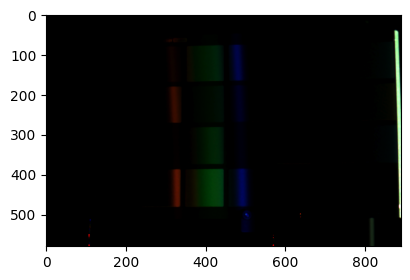

In [20]:
plt.figure(figsize=(5,3))
plt.imshow(hdr_imgs[300])

## Bring depth

In [21]:
if date == "1003":
    depth = np.load(os.path.join(real_data_dir,'2023%s_color_checker.npy'%date))[:,:,2]*1e+3
else:
    depth = np.load(os.path.join(real_data_dir,'./2023%s_depth.npy'%date))[:,:,2]*1e+3

(<matplotlib.image.AxesImage at 0x2a0a9db3ec8>,
 <matplotlib.colorbar.Colorbar at 0x2a0a9dc6508>)

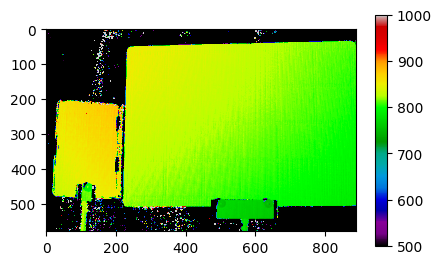

In [22]:
plt.figure(figsize=(5,3))
plt.imshow(depth, vmin=500, vmax = 1000, cmap='nipy_spectral'), plt.colorbar()

In [23]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

## Depth dependent peak illumination index

In [24]:
first_illum_idx = np.load(os.path.join('./dataset/image_formation/20231007/npy_data/first_illum_idx_final_transp_3.npy'))

In [25]:
first_illum_idx = first_illum_idx.reshape(len(new_wvls), len(depth_arange), cam_H*cam_W).transpose(1,0,2)

### Get Mask for uncaptured wavelengths

In [26]:
first_illum_idx.shape

(301, 47, 516200)

In [27]:
# NEED TO DEFINE MASK
Mask = np.ones_like(first_illum_idx)
Mask[first_illum_idx >= 318] = 0
Mask[first_illum_idx < 0 ] = 0

In [28]:
Mask_reshape = Mask.reshape(301,47,580,890)

In [29]:
first_illum_idx[first_illum_idx >= 318] = 317
first_illum_idx[first_illum_idx < 0 ] = 0

In [30]:
first_illum_idx_reshape = first_illum_idx.reshape(301,47,580,890)

### zero order

In [31]:
zero_illum_idx = np.zeros(shape=(cam_H * cam_W))
hdr_imgs_reshape = hdr_imgs.reshape(n_illum, cam_H*cam_W, 3)

for i in range(cam_H*cam_W):
    max_idx = np.argmax(hdr_imgs_reshape[:,i].mean(axis = 1))
    zero_illum_idx[i] = max_idx

zero_illum_idx = np.round(zero_illum_idx)

## Get valid first order illumination idx

In [32]:
# f(x, y, z) = (430 - 660) index

In [33]:
real_img_illum_idx = np.zeros(shape=(len(new_wvls), cam_H*cam_W))
mask_idx = np.zeros(shape=(len(new_wvls), cam_H*cam_W))
for i in range(cam_H*cam_W):
        if (depth[i] < 600) or (depth[i] > 900):
                depth[i] = 600
        depth_idx = np.where(depth_arange == depth[i])[0][0]
        real_img_illum_idx[:,i]= first_illum_idx[depth_idx,:,i]
        mask_idx[:,i] = Mask[depth_idx,:,i]

In [34]:
a = mask_idx.reshape(47, 580, 890)

In [35]:
a[:,260,390]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [36]:
real_img_illum_idx = real_img_illum_idx.astype(np.int16).reshape(len(new_wvls), cam_H, cam_W)
real_img_illum_idx_final = np.stack((real_img_illum_idx, real_img_illum_idx, real_img_illum_idx), axis = 3)

### Diffraction grating efficiency

In [37]:
real_img_illum_idx_reshape = real_img_illum_idx.reshape(len(new_wvls), cam_H*cam_W)

In [38]:
# DG efficiency for all pixels
DG_efficiency_image = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))

for i in range(cam_H * cam_W):
    if zero_illum_idx[i] > real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
        DG_efficiency_image[i,:] =  DG_efficiency[0]

    elif zero_illum_idx[i] < real_img_illum_idx_reshape[0,i]: # +1 order
        DG_efficiency_image[i,:] =  DG_efficiency[2]
    else: # else
        DG_efficiency_image[i,:] = 0

In [39]:
DG_efficiency_image_reshape = DG_efficiency_image.reshape(cam_H, cam_W, len(new_wvls))

### Simulation

#### DEBUG

In [40]:
white_pattern = np.ones(shape = (1, 3)) * 0.8
white_pattern_hyp = white_pattern @ PEF.T
                    # 47, 1
# Simulated_I_RGB = (ref_CC[:,18][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * DG_efficiency[2][:,np.newaxis]) * CRF

In [41]:
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

GT_I_RGB = hdr_imgs[real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3)    

In [42]:
# p = 2
# for i in range(380, 450, 2):
#     fig, ax = plt.subplots()
#     plt.ylim([0,1])
#     plt.xlabel('illumination index')
#     plt.ylabel('intensity')
    
#     dg = DG_efficiency_image_reshape[all_patches_center_pts[p,1],all_patches_center_pts[p,0]][:,np.newaxis]
    
#     plt.plot((ref_CC[:,p][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * DG_efficiency[0][:,np.newaxis]) * CRF, label= 'GT')
#     plt.plot(GT_I_RGB[all_patches_center_pts[p,1],i], label = "Real captured")
#     plt.legend()
#     plt.title('%02d patch'%i)
#     # plt.savefig('./%02d_patch.png'%i)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


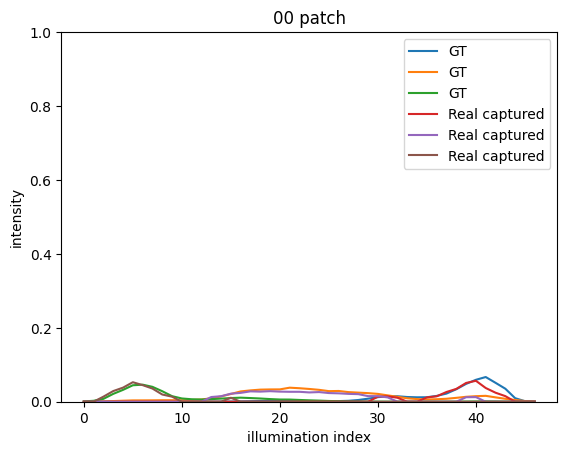

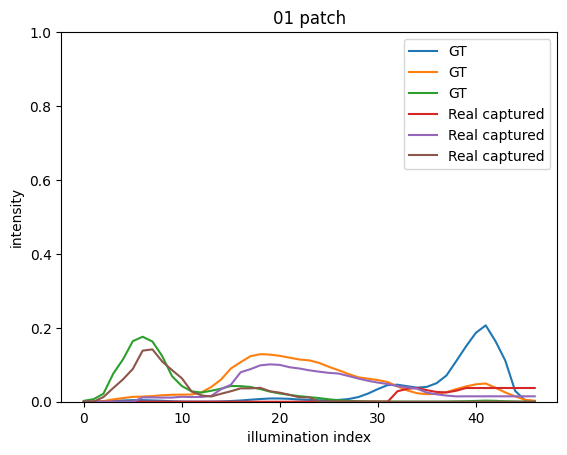

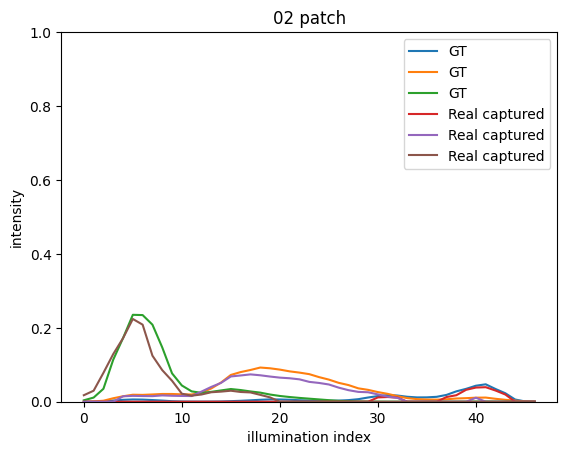

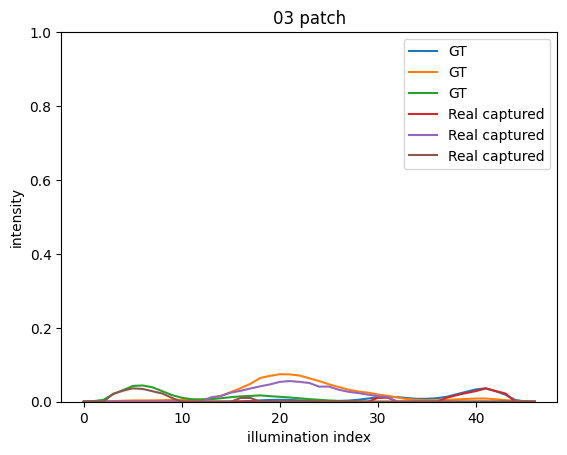

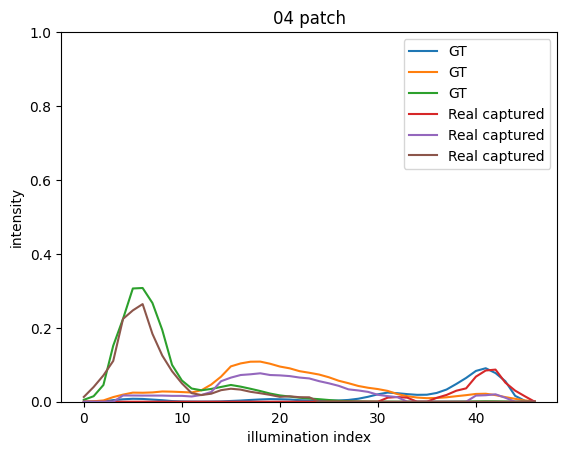

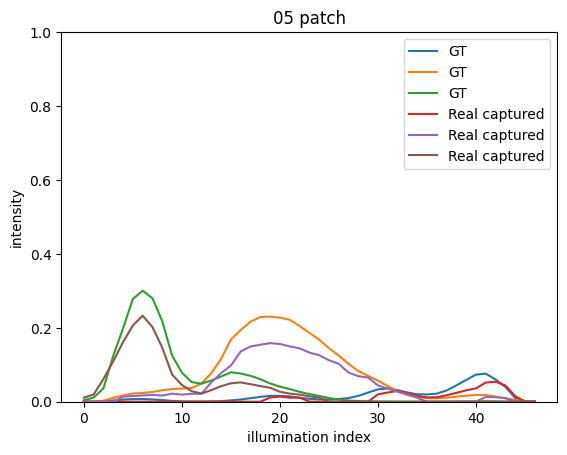

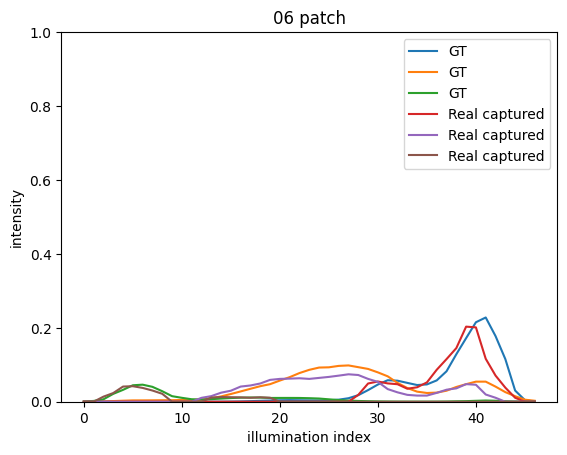

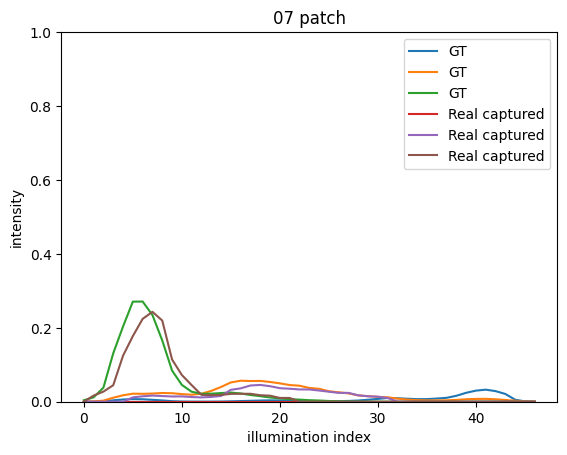

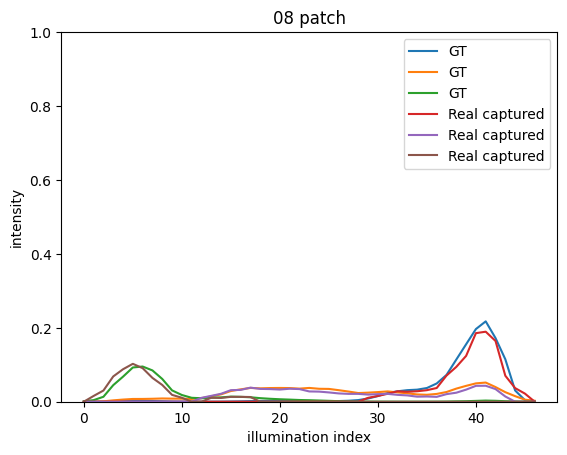

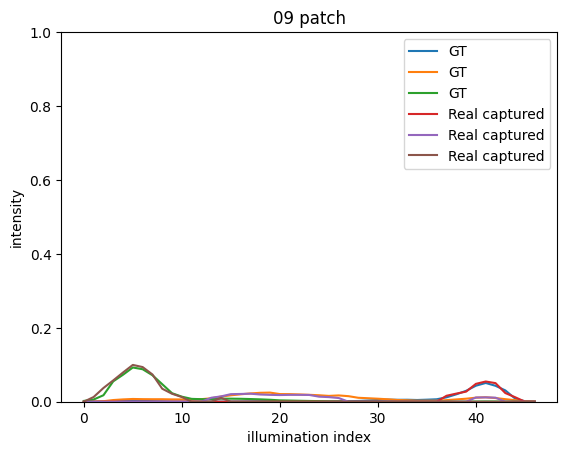

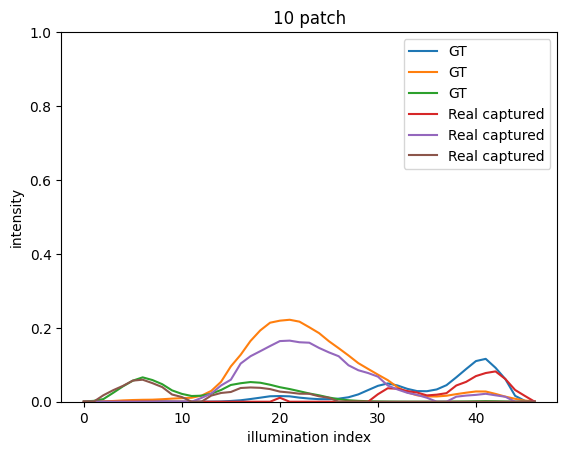

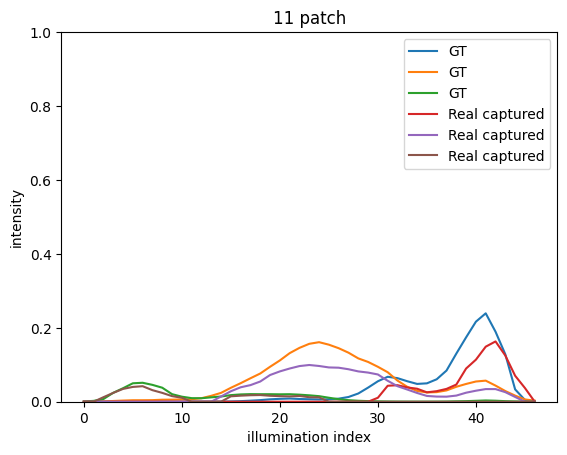

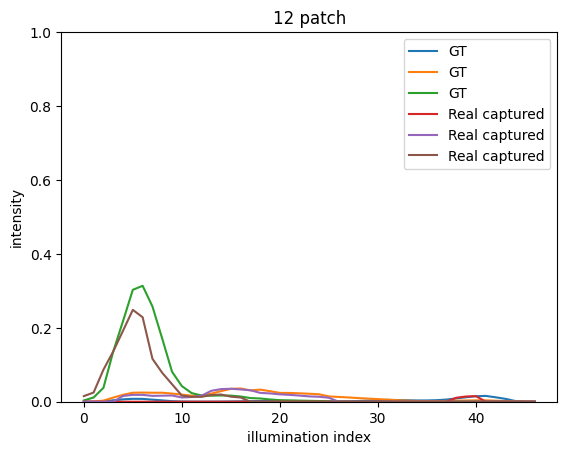

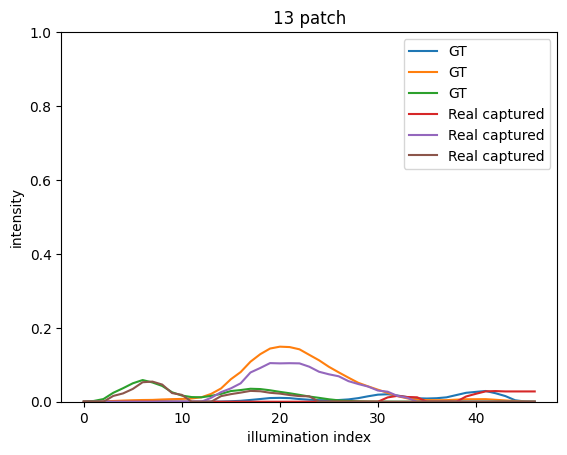

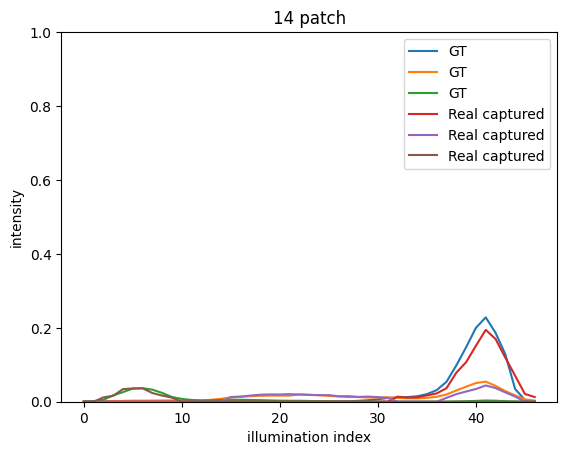

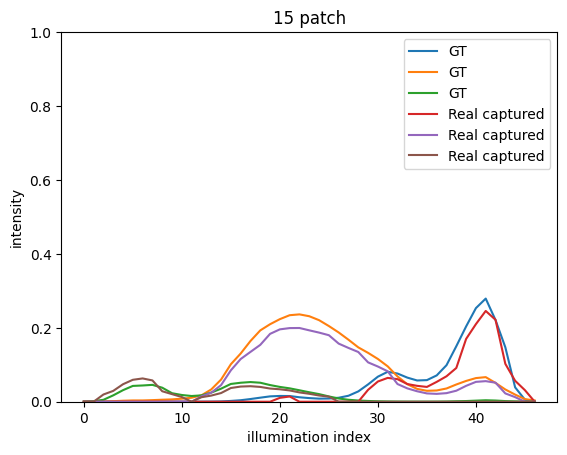

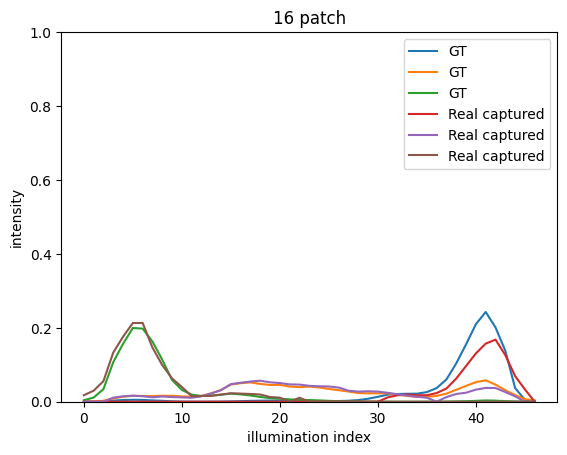

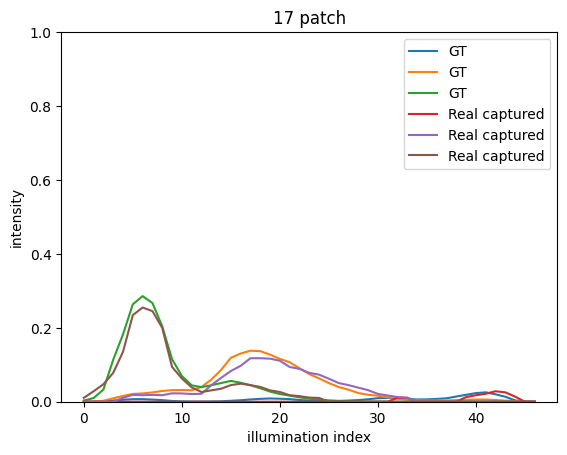

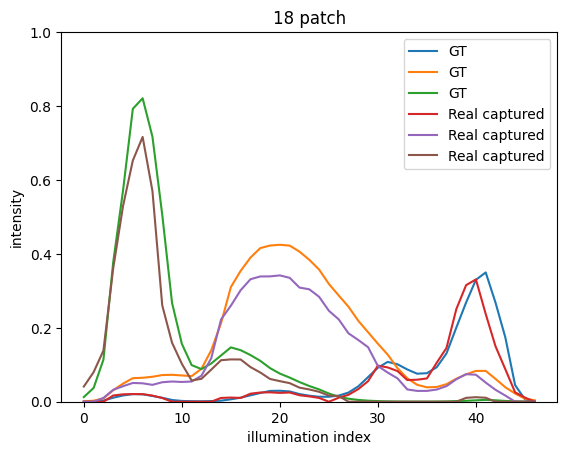

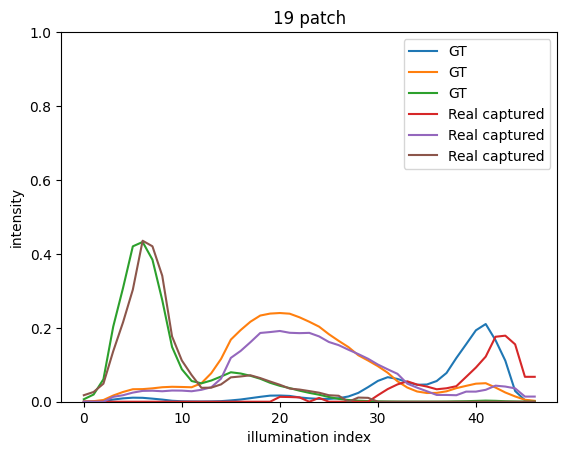

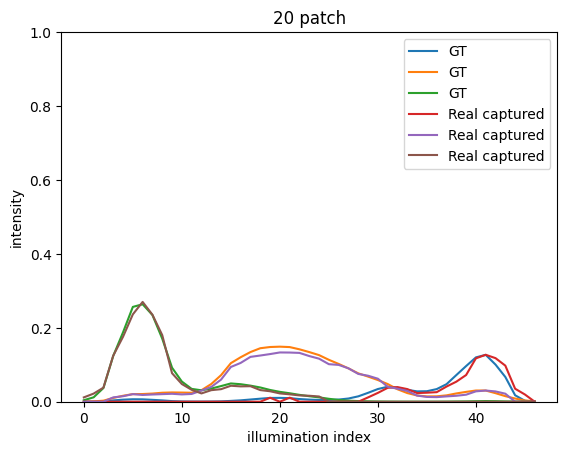

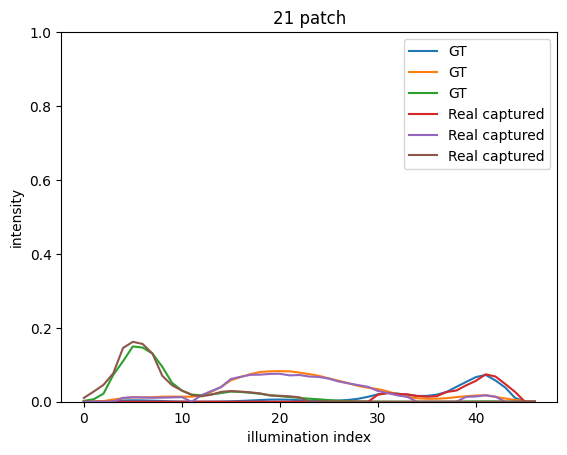

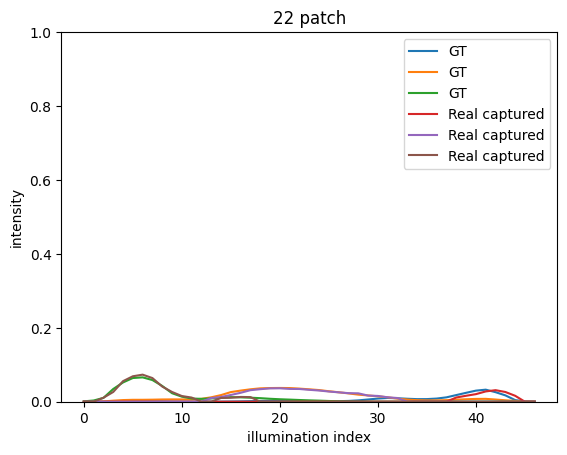

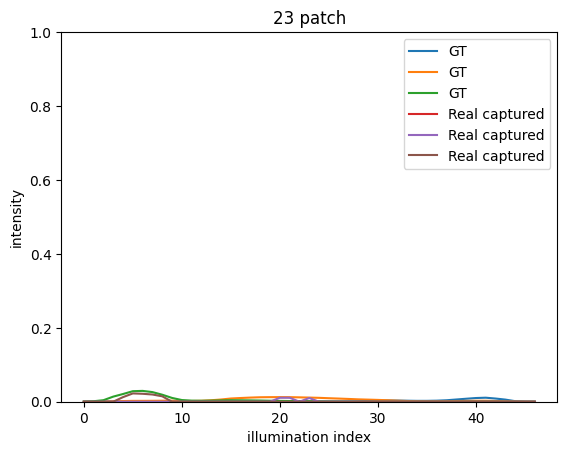

In [46]:
for i in range(len(all_patches_center_pts)):
    fig, ax = plt.subplots()
    plt.ylim([0,1])
    plt.xlabel('illumination index')
    plt.ylabel('intensity')
    
    dg = DG_efficiency_image_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]][:,np.newaxis]
    
    plt.plot((ref_CC[:,i][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * dg) * CRF, label= 'GT')
    plt.plot(GT_I_RGB[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = "Real captured")
    plt.legend()
    plt.title('%02d patch'%i)
    # plt.savefig('./%02d_patch.png'%i)

In [44]:
efewef

NameError: name 'efewef' is not defined

## SVD

In [47]:
n_lambda = 47
weight_D = 0.5
device = 'cuda:0'
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

# D matrix
i_mat = np.eye(n_lambda)
diagonal_indices = np.diag_indices(i_mat.shape[0])
new_diagonal_indices_col = np.copy(diagonal_indices[1])
new_diagonal_indices_col[:-1] = diagonal_indices[1][:-1] + 1
i_mat[(diagonal_indices[0], new_diagonal_indices_col)] = -1
D = i_mat
D[-1] = i_mat[-2]

D = torch.tensor(D, device=device)

# to tensor, device
CRF = torch.tensor(CRF, device=device).type(torch.float32)
PEF = torch.tensor(PEF, device=device).type(torch.float32)
hdr_imgs_t = torch.tensor(hdr_imgs, device=device)
first_illum_idx_final_transp_t = torch.tensor(real_img_illum_idx_final, device=device)
DG_efficiency_image_t = torch.tensor(DG_efficiency_image.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls

# pattern
white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

CRF_sum = torch.tensor(CRF, device=device).sum(axis = 1)

total_hyp_ref = []

# summation of Image RGB channel
I_C = hdr_imgs_t[first_illum_idx_final_transp_t.long(), x, y, z].permute(1, 2, 0, 3).sum(axis = 3).reshape(-1, n_lambda, 1) # H x W, wvls, 1
A = (CRF_sum.unsqueeze(dim = 0) * white_patt_hyp * DG_efficiency_image_t).unsqueeze(dim =2) # HxW, wvls, 1


c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [48]:
I_C_reshape = I_C.reshape(580,890,47).detach().cpu().numpy()

In [49]:
A_diag = torch.diag_embed((A*A).squeeze())

weight_D_DT = (weight_D*D.T@D).unsqueeze(dim = 0)

csj_x = torch.linalg.solve(A_diag + weight_D_DT, A*I_C.reshape(cam_H*cam_W, n_lambda,1))

total_hyp_ref = csj_x.squeeze()
total_hyp_ref = total_hyp_ref.reshape(cam_H, cam_W, n_lambda)

In [50]:
total_hyp_ref = total_hyp_ref.detach().cpu().numpy()

In [51]:
all_patches_center_pts.shape

(24, 2)

### Inverse DG

In [52]:
# DG efficiency for all pixels
DG_efficiency_image_inv = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))

for i in range(cam_H * cam_W):
    if zero_illum_idx[i] <= real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
        DG_efficiency_image_inv[i,:] =  DG_efficiency[0]
    elif zero_illum_idx[i] > real_img_illum_idx_reshape[0,i]: # +1 order
        DG_efficiency_image_inv[i,:] =  DG_efficiency[2]
    else: # else
        DG_efficiency_image_inv[i,:] = 0

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


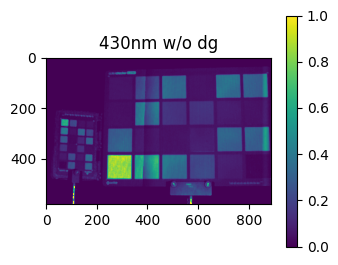

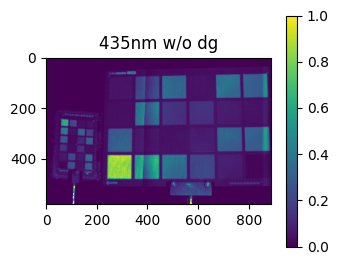

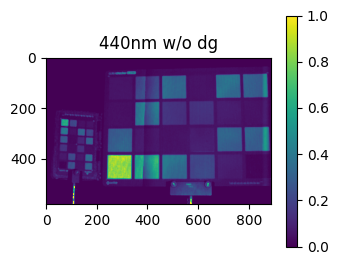

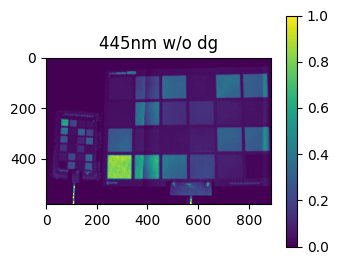

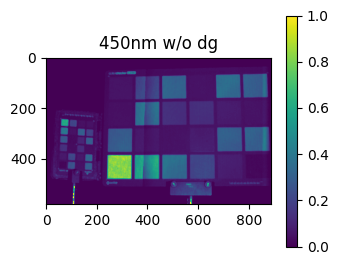

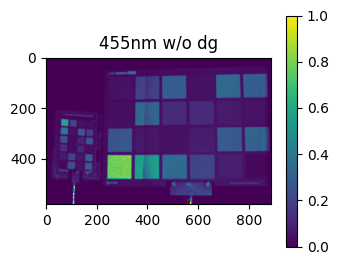

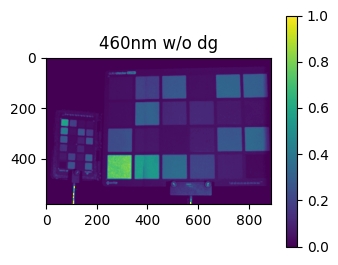

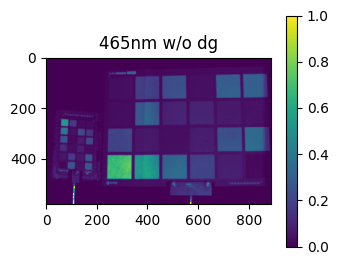

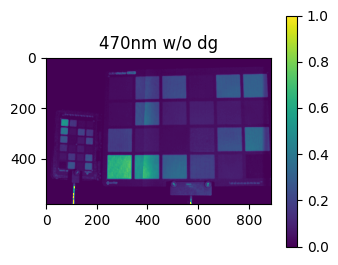

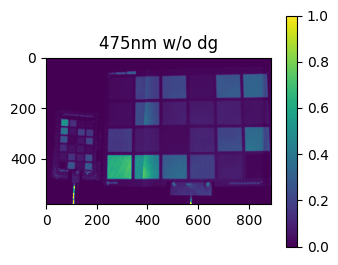

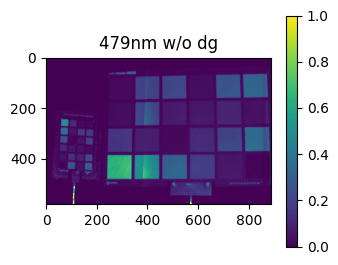

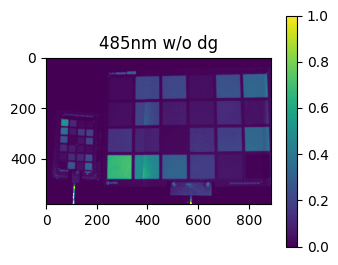

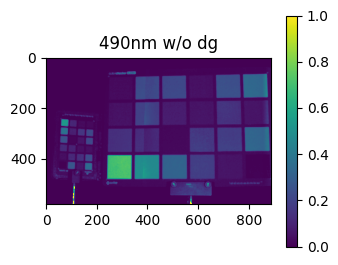

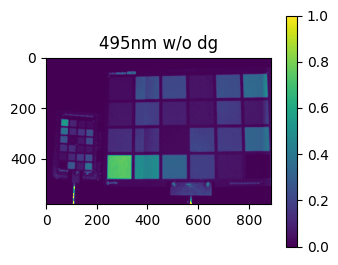

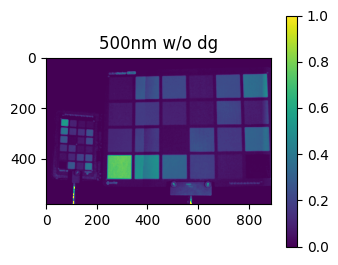

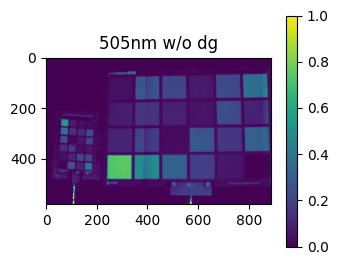

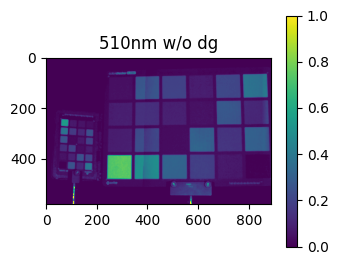

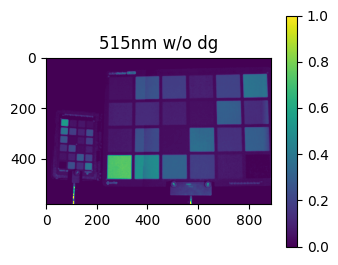

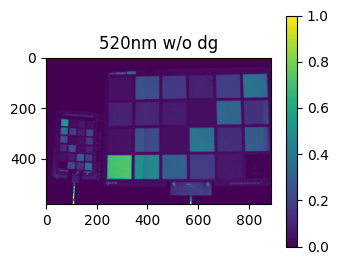

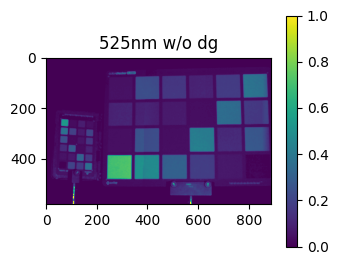

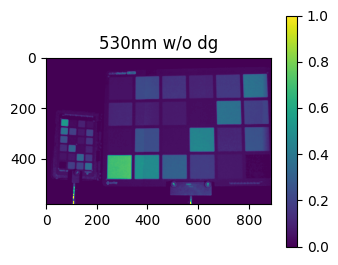

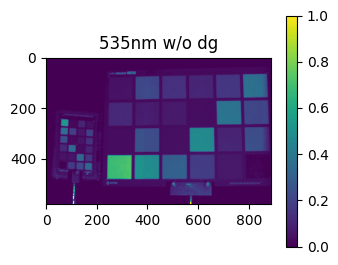

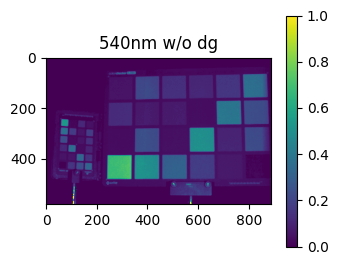

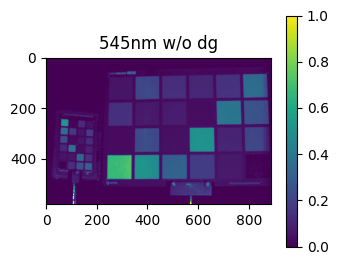

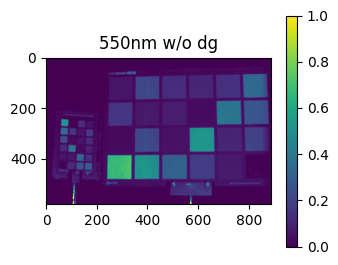

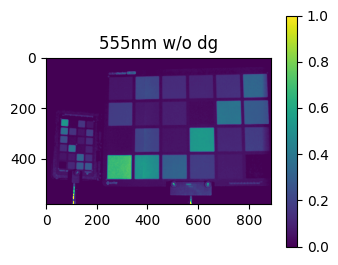

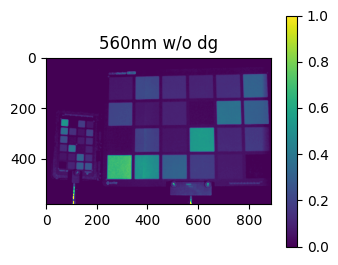

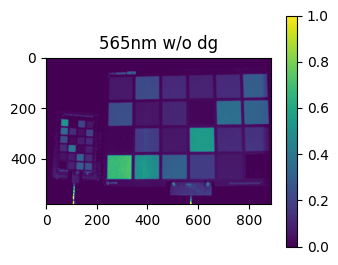

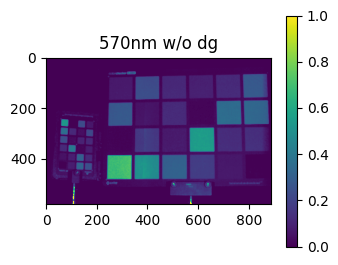

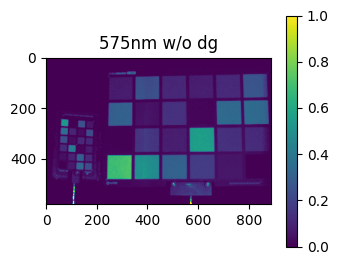

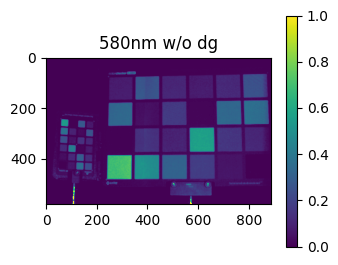

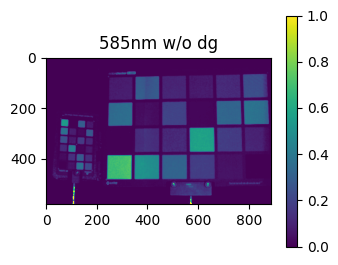

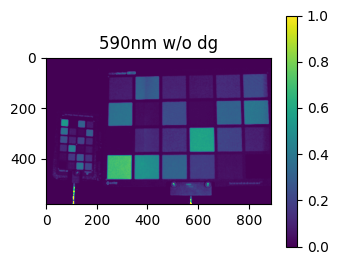

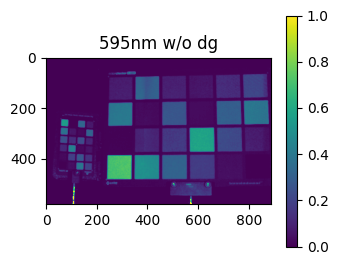

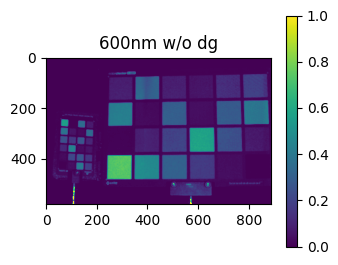

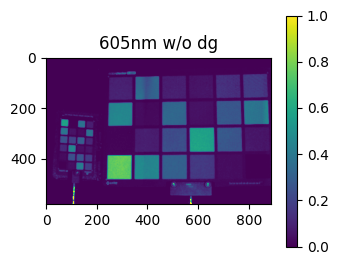

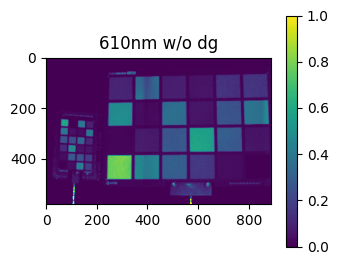

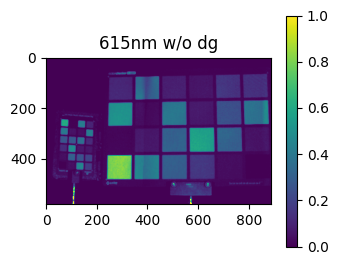

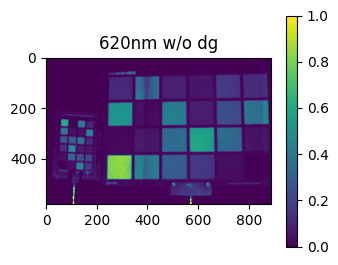

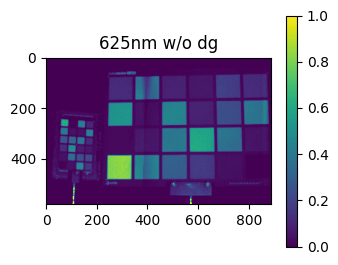

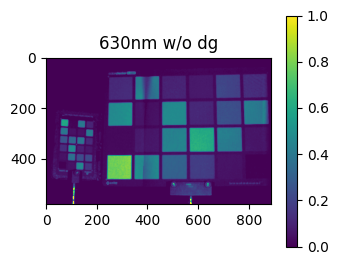

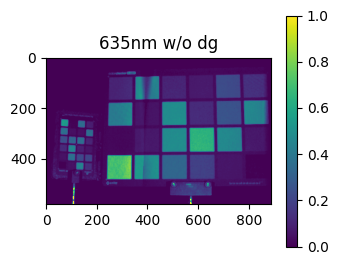

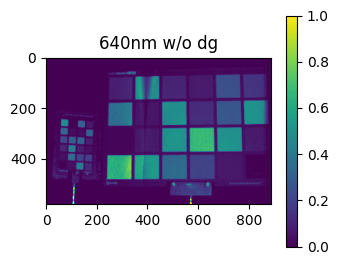

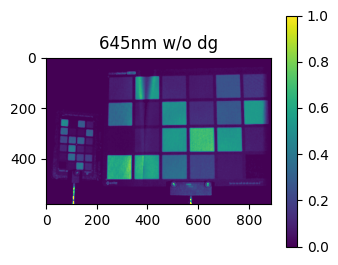

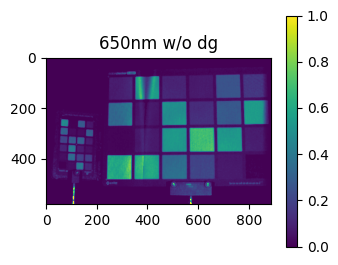

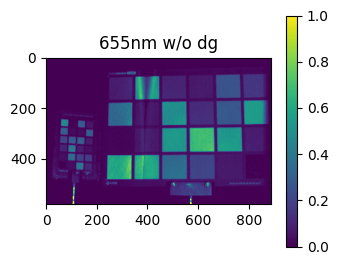

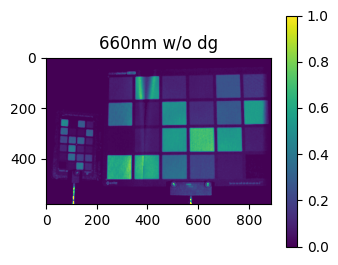

In [53]:
grid_rows = 7
grid_cols = 7
    
# # Create a new figure
# plt.figure(figsize=(20, 20))

# for i in range(1, 48):
#     plt.subplot(grid_rows, grid_cols, i)
#     # plt.imshow(img, cmap='gray')  # you can specify a different colormap if you want
#     plt.imshow(total_hyp_ref[:,:,i-1], vmin = 0, vmax = 1), plt.title('%dnm'%(new_wvls[i-1]*1e+9)), plt.colorbar()
#     plt.axis('off')  # hide axis labels and ticks

for i in range(47):
    plt.figure(figsize=(8, 3))
    # plt.subplot(121), plt.imshow(total_hyp_ref[:,:,i] / DG_efficiency_image_inv.reshape(580,890,47)[:,:,i], vmin = 0, vmax = 1), plt.title('%dnm w/o dg'%(new_wvls[i]*1e+9)), plt.colorbar()
    plt.subplot(121), plt.imshow(total_hyp_ref[:,:,i], vmin = 0, vmax = 1), plt.title('%dnm w/o dg'%(new_wvls[i]*1e+9)), plt.colorbar()

    # implot = plt.imshow(total_hyp_ref[:,:,i], vmin = 0, vmax = 1), plt.title('%dnm w dg'%(new_wvls[i]*1e+9)), plt.colorbar()
    # plt.scatter(450, 150, c = 10)
    # plt.show()
    # plt.savefig('./%dnm'%(new_wvls[i]*1e+9))

In [54]:
total_hyp_ref.shape, all_patches_center_pts.shape

((580, 890, 47), (24, 2))

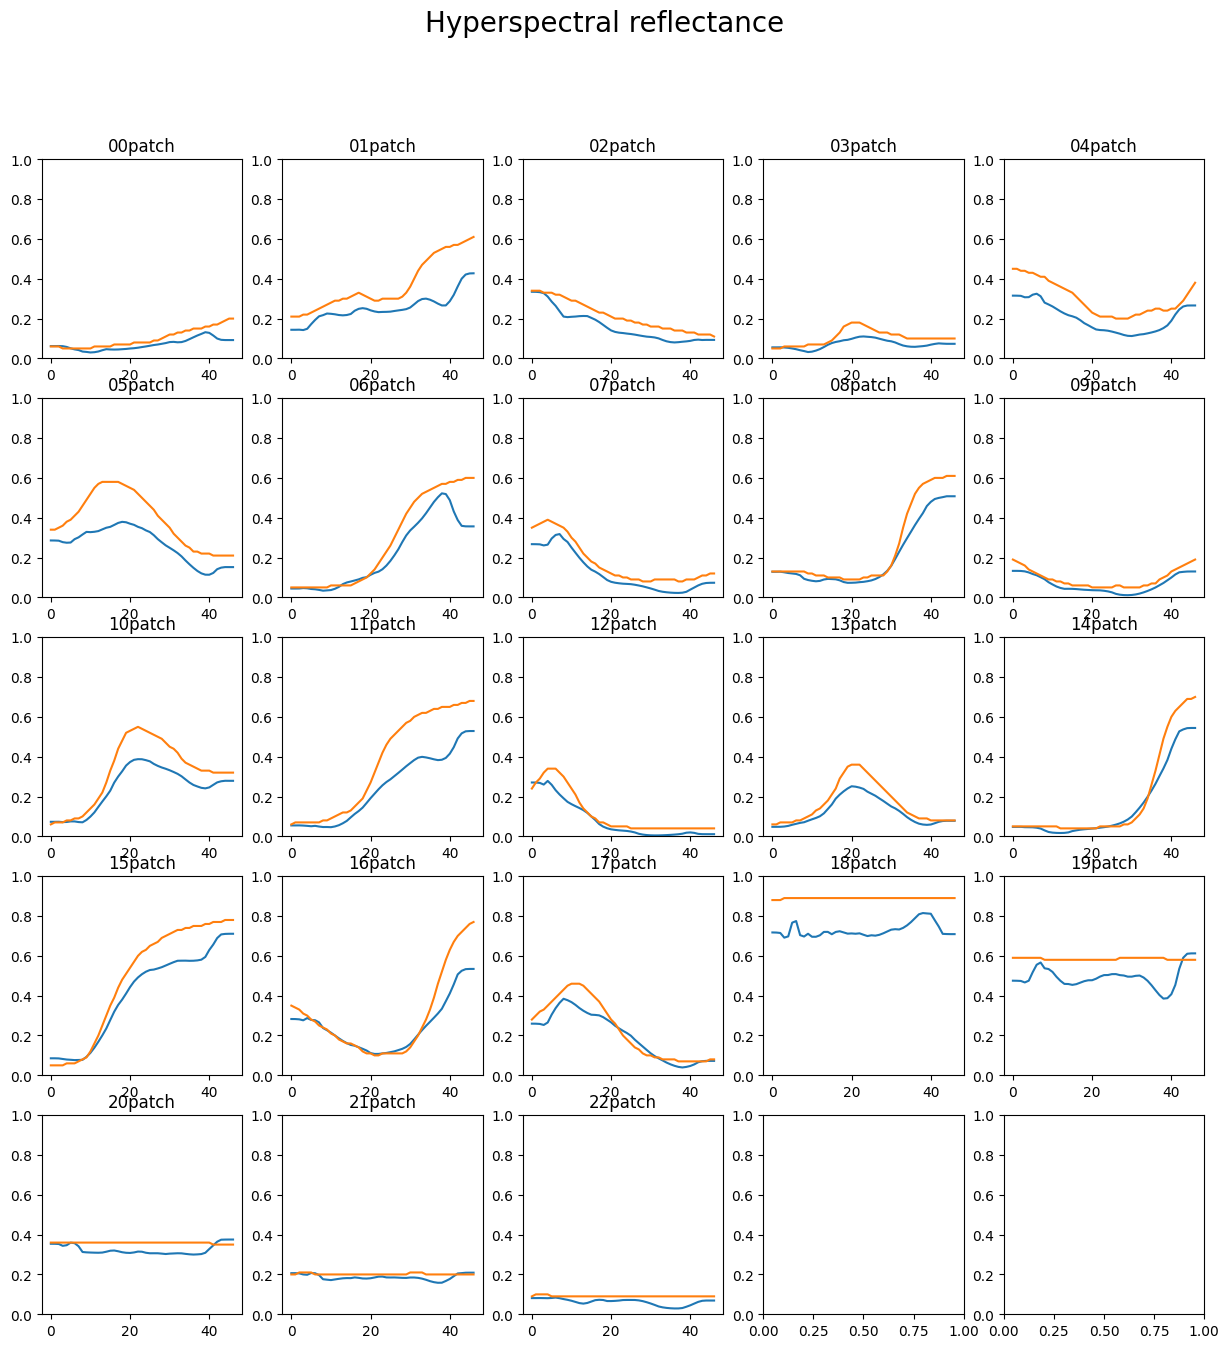

In [55]:
# Creating a figure
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Hyperspectral reflectance', fontsize=20)

# Plotting data
for i, ax in enumerate(axs.flat[:23]):
    ax.set_ylim(0, 1)
    ax.plot(total_hyp_ref[all_patches_center_pts[i,1]+10,all_patches_center_pts[i,0]+10], label = 'estimated')
    ax.plot(ref_CC[:,i][:,np.newaxis], label = 'gt')
    ax.set_title('%02dpatch'%i)
    
# for i in range(24):
#     plt.figure(figsize=(5, 3))
#     plt.ylim([0,1])
#     plt.plot(total_hyp_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = 'estimated')
#     plt.plot(ref_CC[:,i][:,np.newaxis], label = 'gt')
#     plt.title('%02dpatch'%i)
#     plt.legend()
#     plt.savefig('./%02dpatch'%(i))

In [56]:
x_wvl = (new_wvls.detach().cpu().numpy()*1e+9).astype(np.int16)

In [57]:
# pts2 = np.array([750,87])

# pts = np.array([645,370])

# fig, ax = plt.subplots()
# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# plt.ylim([0,1])
# plt.xlabel('wavelengths')
# plt.ylabel('reflectance')
# plt.plot(x_wvl, total_hyp_ref[pts[1],pts[0]], linestyle = '-', marker ='o', markersize = '4', color = 'red', label = 'nose')
# plt.plot(x_wvl, total_hyp_ref[pts2[1],pts2[0]], linestyle = '-', marker ='o', markersize = '4', color = 'blue', label= 'leaf')
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)

# # plt.plot(ref_CC[:,i][:,np.newaxis] , label= 'GT')
# plt.legend(fontsize="13")
# # plt.title('%02d patch'%i)
# # plt.savefig('./%02d_patch.png'%i)

In [58]:

# # for i in range(len(all_patches_center_pts)):
# fig, ax = plt.subplots()

# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# # plt.plot(x_wvl, total_hyp_ref[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label= 'Ours', linestyle = '-', marker ='o', markersize = '4', color = 'red')
# plt.plot(x_wvl, ref_CC[:,8][:,np.newaxis] , label= 'GT', linestyle = '-', marker ='o', markersize = '4', color = 'black')

# # plt.plot(x_wvl, total_hyp_ref[147,388], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
# # plt.plot(x_wvl, total_hyp_ref[147,451], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')

# for i in range(100):
        
#     plt.plot(x_wvl, total_hyp_ref[263,382], linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,382 + i], linestyle = '-', marker ='o', markersize = '4', color = 'orange')

#     # plt.plot(x_wvl, total_hyp_ref[263,382], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,460], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')


# plt.legend(fontsize="13")
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.title('%02d patch'%i)

In [59]:

# # for i in range(len(all_patches_center_pts)):
# fig, ax = plt.subplots()

# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# plt.plot(x_wvl, ref_CC[:,8][:,np.newaxis] , label= 'GT', linestyle = '-', marker ='o', markersize = '4', color = 'black')

# for i in range(100):
        
#     # plt.plot(x_wvl, total_hyp_ref[263,382], linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     plt.plot(x_wvl, total_hyp_ref[262,382 + i], linestyle = '-', marker ='o', markersize = '4', color = 'orange')

#     # plt.plot(x_wvl, total_hyp_ref[263,382], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,460], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')


# plt.legend(fontsize="13")
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.title('%02d patch'%i)

In [60]:

# # for i in range(len(all_patches_center_pts)):
# fig, ax = plt.subplots()

# plt.ylim([0,1])
# plt.xlabel('wavelengh', fontsize=18)
# plt.ylabel('reflectance',fontsize=18)
# plt.plot(x_wvl, ref_CC[:,8][:,np.newaxis] , label= 'GT', linestyle = '-', marker ='o', markersize = '4', color = 'black')

# for i in range(100):
        
#     # plt.plot(x_wvl, total_hyp_ref[263,382], linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     plt.plot(x_wvl, total_hyp_ref[262,382 + i], linestyle = '-', marker ='o', markersize = '4', color = 'orange')

#     # plt.plot(x_wvl, total_hyp_ref[263,382], label= 'Ours left', linestyle = '-', marker ='o', markersize = '4', color = 'red')
#     # plt.plot(x_wvl, total_hyp_ref[262,460], label= 'Ours right', linestyle = '-', marker ='o', markersize = '4', color = 'orange')


# plt.legend(fontsize="13")
# plt.grid(linestyle = '--')
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.title('%02d patch'%i)

In [61]:
np.save('./total_hyp_ref.npy', total_hyp_ref)

In [62]:
# CRF = np.array(CRF.detach().cpu().numpy())
rgb_img = total_hyp_ref@CRF

plt.figure()
plt.imshow(rgb_img*0.02)
# plt.savefig('./rgb.png')

TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'